# Subdivision and simplification with pymeshlab

This notebook contains functions for subdividing and simplifying meshes using pymeshlab while preserving UV information. This is useful since it allows one to increase or decrease the mesh "resolution" as needed when the mesh is deformed.

A limitation of this code is that it ensures correct transfer of UV information by cutting meshes along their UV seams. This does not alter the mesh position but it does alter the topology.

**Other notes**

- Blender make multi-color surfaces (using texture and material preview) and Semi-Transparent too. Can surely be done without UV map (texture coordinates I think)

**Other options**

The other option, generally speaking, is to UV map from each timepoint mesh separately. Then use a reproducible algorithm of sorts to make sure one has consistent maps. Overall this is the strategy of Noah and Dillon. But this interferes with the idea of a graphical, interactive way of making UV maps! Maybe we can still learn something from the tubular paper.

In [1]:
#| default_exp remesh_igl

In [2]:
#| export

from blender_tissue_cartography import io as tcio

import numpy as np
import igl

import warnings
import os

In [3]:
import matplotlib.pyplot as plt

### Subdivision with `igl`

In [4]:
#| export

def subdivide_igl(mesh, reglue=True, decimals=10):
    """
    Refine mesh by edge subdivision using pymeshlab.
    
    Preserves UV information, but cuts the mesh along seams. Can glue back after. Subdivides all edges.
    
    Parameters
    ----------
    mesh : ObjMesh
        Initial mesh.

    Returns
    -------
    mesh_subdiv : ObjMesh
        Subdivided mesh.
    reglue : bool
        Glue back after cutting
    decimals : int
        Decimal precision for merging vertices when regluing.
    """
    mesh_cut = mesh.cut_along_seams()
    S, new_faces = igl.loop_subdivision_matrix(mesh_cut.vertices.shape[0], mesh_cut.tris)
    new_verts = S.dot(mesh_cut.vertices)
    new_textures = S.dot(mesh_cut.texture_vertices)
    mesh_subdiv = tcio.ObjMesh(vertices=new_verts, texture_vertices=new_textures,
                               faces=[[[v,v] for v in fc] for fc in new_faces])
    if reglue:
        mesh_subdiv = tcio.glue_seams(mesh_subdiv, decimals=decimals)
    return mesh_subdiv

In [5]:
# can we somehow avoid the requirement to cut the mesh?

In [6]:
mesh_test = tcio.ObjMesh.read_obj("movie_example/initial_uv.obj")

In [7]:
mesh_subdiv = subdivide_igl(mesh_test) 

In [8]:
mesh_subdiv.write_obj("movie_example/mesh_subdivided_igl.obj")

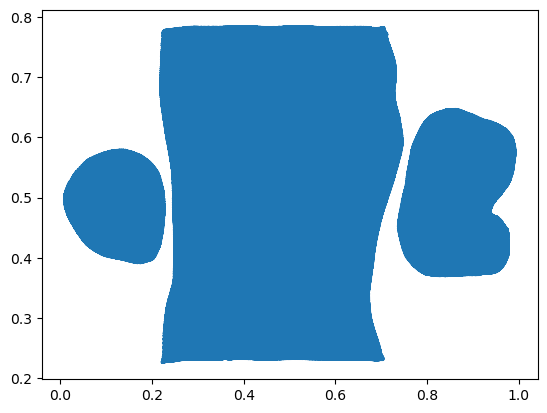

In [9]:
plt.triplot(*mesh_subdiv.texture_vertices.T, mesh_subdiv.tris)

In [16]:
mesh_subdiv_glued = tcio.glue_seams(mesh_subdiv, decimals=8)

In [17]:
mesh_subdiv_glued.vertices.shape, mesh_subdiv.vertices.shape

((80873, 3), (81663, 3))

In [18]:
mesh_subdiv_glued.write_obj("movie_example/mesh_subdivided_glued_igl.obj")

In [19]:
igl.boundary_loop(mesh_subdiv_glued.tris)


array([14715, 63899, 14723, 63941, 14732, 63898])

## Trying to only subdivide certain faces

In [9]:
mesh_cut = meshes_wrapped[-1].cut_along_seams()

In [10]:
mesh_cut.tris.shape, 40420/2

((40420, 3), 20210.0)

In [11]:
S, new_faces = igl.loop_subdivision_matrix(mesh_cut.vertices.shape[0], mesh_cut.tris[20210:])

In [12]:
new_textures = S.dot(mesh_cut.texture_vertices)

In [22]:
S.shape

(51570, 20623)

In [13]:
unique_faces = np.unique(np.vstack([mesh_cut.tris, new_faces]), axis=1)

In [14]:
new_verts = S.dot(mesh_cut.vertices)
mesh_subdiv_partial = tcio.ObjMesh(vertices=new_verts, texture_vertices=new_textures,
                                   faces=[[[v,v] for v in fc] for fc in unique_faces])


In [15]:
mesh_subdiv_partial.write_obj("movie_example/mesh_subdivided_partial_igl.obj")

In [106]:
new_faces.max()

51569

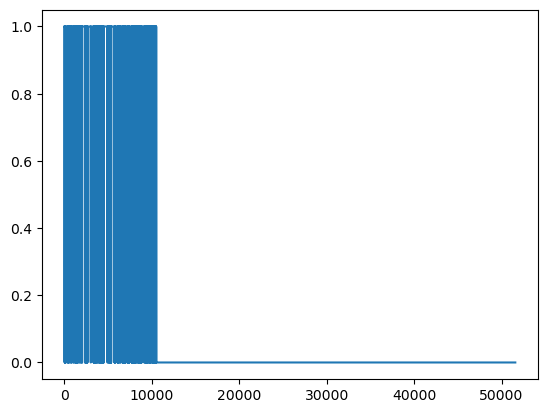

In [21]:
plt.plot(np.isnan(new_verts).any(axis=1))

### simplification/decimation with `igl`

Assigning texture coordinates simply based on the birth vertex is not great. can we do better? I guess not :\

In [30]:
_, vertices_new, faces_new, birth_faces, birth_vertices = igl.qslim(new_mesh.vertices, new_mesh.tris,
                                                                    max_m=int(new_mesh.tris.shape[0]/4))


### simplification/decimation with `igl`

Assigning texture coordinates simply based on the birth vertex is not great. can we do better? I guess not :\

In [31]:
new_new_mesh = tcio.ObjMesh(vertices=vertices_new, texture_vertices=new_mesh.texture_vertices[birth_vertices],
                            faces=[[[v,v] for v in fc] for fc in faces_new])

In [32]:
new_new_mesh = tcwrap.smooth_laplacian_texture(new_new_mesh, n_iter=5)

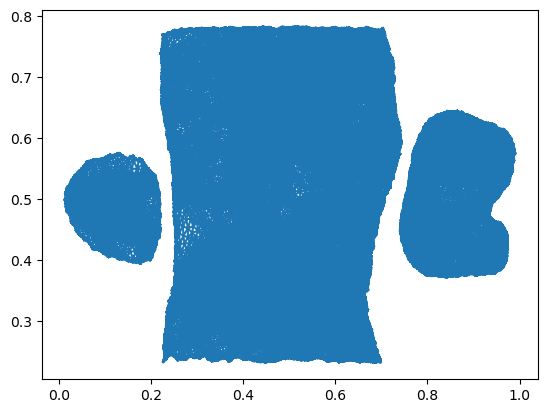

In [33]:
plt.triplot(*new_new_mesh.texture_vertices.T, new_new_mesh.tris)

In [34]:
new_new_mesh.write_obj("movie_example/mesh_subdivided_simplified_igl.obj")